In [2]:
import numpy as np
import matplotlib.pyplot as plt
from pyTMD.time import convert_calendar_dates, datetime_to_list
from pyTMD.io import model, GOT, ATLAS
from pyTMD.predict import time_series, infer_minor, map
from datetime import datetime, timedelta

In [3]:
lon = 122.26672
lat = 23.76175

# Model parameters
model_directory = '/media/X/temp/tide/GOT4.10/'
model_format = 'netcdf'
compressed = False
model_name = 'GOT4.10'


In [4]:
# Create model object
def get_tide_model(model_name, model_directory, model_format, compressed=False):
    return model(model_directory, format=model_format, compressed=compressed).elevation(model_name)

tide_model = get_tide_model(model_name, model_directory, model_format, compressed)

In [5]:
# Load and interpolate tidal constants
def get_tide_constants(lon, lat, tide_model, model_name):
    if 'GOT' in model_name:
        constituents = GOT.read_constants(tide_model.model_file, compressed=tide_model.compressed)
        amp, ph = GOT.interpolate_constants(np.array([lon]), np.array([lat]),  
                        constituents, scale=tide_model.scale, 
                        method='spline', extrapolate=True)

    elif 'atlas' in model_name:
        constituents = ATLAS.read_constants(tide_model.grid_file, tide_model.model_file, type=tide_model.type, compressed=tide_model.compressed)
        amp, ph, D = ATLAS.interpolate_constants(
                        np.atleast_1d(lon), np.atleast_1d(lat),
                        constituents, type=tide_model.type, scale=tide_model.scale,
                        method='spline', extrapolate=True)

    return constituents, amp, ph

constituents, amp, ph = get_tide_constants(lon, lat, tide_model, model_name)
print(amp)
print(ph)
print(amp.shape)
print(ph.shape)

[[0.030943674966692924 0.15202389657497406 0.056997451931238174
  0.1767793744802475 0.08910463750362396 0.4602945148944855
  0.18891607224941254 0.05152113735675812 0.0069605265744030476
  0.0009311279281973839]]
[[65.07211380768192 77.45015828198338 96.73382453549121 98.68804410986941
  289.2768677108055 297.7108604300181 322.32758961389067
  322.73642083194557 285.5496812920537 239.01022028769088]]
(1, 10)
(1, 10)


In [5]:
print(len(constituents))
print(len(constituents.fields))
print(constituents.fields)

10
10
['q1', 'o1', 'p1', 'k1', 'n2', 'm2', 's2', 'k2', 's1', 'm4']


In [7]:
start_date = datetime(2023, 7, 25)
end_date = datetime(2023, 7, 28)

def get_tide_time(start_date, end_date):
# Only one day timing (24 hours, 1-hour intervals)
# hours = np.arange(0, 24, 1)
# tide_time = convert_calendar_dates(2023, 7, 24, hour=hours)

# Create a list to hold all the hours arrays
# all_hours = []
# all_tide_times = []

# Generate arrays for each day
# for day in range(25, 29):  # 25, 26, 27, 28
#    hours = np.arange(0, 24, 1)
#    all_hours.append(hours)
#    
#    tide_time = convert_calendar_dates(2023, 7, day, hour=hours)
#    all_tide_times.append(tide_time)

# Concatenate all the arrays
# hours = np.concatenate(all_hours)
# tide_time = np.concatenate(all_tide_times)
# print(tide_time)

# Create start and end date


# Generate a list of every hour between start and end date
    dtime = []
    tide_time = []
    while start_date <= end_date:
        dtime.append(start_date)
        dtlist = datetime_to_list(start_date)
        tide_time.append(convert_calendar_dates(dtlist[0], dtlist[1], dtlist[2], dtlist[3]))
        start_date += timedelta(hours=1)

    tide_time = np.array(tide_time)
    return tide_time, dtime

tide_time, dtime = get_tide_time(start_date, end_date)
print(tide_time)

[11528.         11528.04166667 11528.08333333 11528.125
 11528.16666667 11528.20833333 11528.25       11528.29166667
 11528.33333333 11528.375      11528.41666667 11528.45833333
 11528.5        11528.54166667 11528.58333333 11528.625
 11528.66666667 11528.70833333 11528.75       11528.79166667
 11528.83333333 11528.875      11528.91666667 11528.95833333
 11529.         11529.04166667 11529.08333333 11529.125
 11529.16666667 11529.20833333 11529.25       11529.29166667
 11529.33333333 11529.375      11529.41666667 11529.45833333
 11529.5        11529.54166667 11529.58333333 11529.625
 11529.66666667 11529.70833333 11529.75       11529.79166667
 11529.83333333 11529.875      11529.91666667 11529.95833333
 11530.         11530.04166667 11530.08333333 11530.125
 11530.16666667 11530.20833333 11530.25       11530.29166667
 11530.33333333 11530.375      11530.41666667 11530.45833333
 11530.5        11530.54166667 11530.58333333 11530.625
 11530.66666667 11530.70833333 11530.75       11530.79

In [8]:
# calculate complex phase in radians for Euler's
def get_tide(amp, ph, constituents, tide_time, format='netcdf'):
    cph = -1j * ph * np.pi / 180.0
    # calculate constituent oscillation
    hc = amp * np.exp(cph)
    c = constituents.fields
    DELTAT = np.zeros_like(tide_time)

    # Predict tide
    tide = time_series(tide_time, hc, c, deltat=DELTAT, corrections=format)
    minor = infer_minor(tide_time,hc, c, deltat=DELTAT, corrections=format)
    tide.data[:] += minor.data[:]
    # convert to centimeters
    tide.data[:] *= 100.0
    # print(tide.data.shape)
    return tide

In [9]:
# Plot tidal height
def plot_tide(tide, dtime):
    miny=int(min(tide.data[:])-20) #-60
    maxy=int(max(tide.data[:])+20) #60
    intervaly=15
    plt.figure(figsize=(18,4))
    plt.plot(dtime, tide.data, marker='o')
    plt.xlabel('Time')
    plt.ylabel('Tidal height')
    plt.yticks(list(range(miny,maxy+1,intervaly)),[str(i) for i in range(miny,maxy+1,intervaly)])
    plt.grid()
    plt.show()

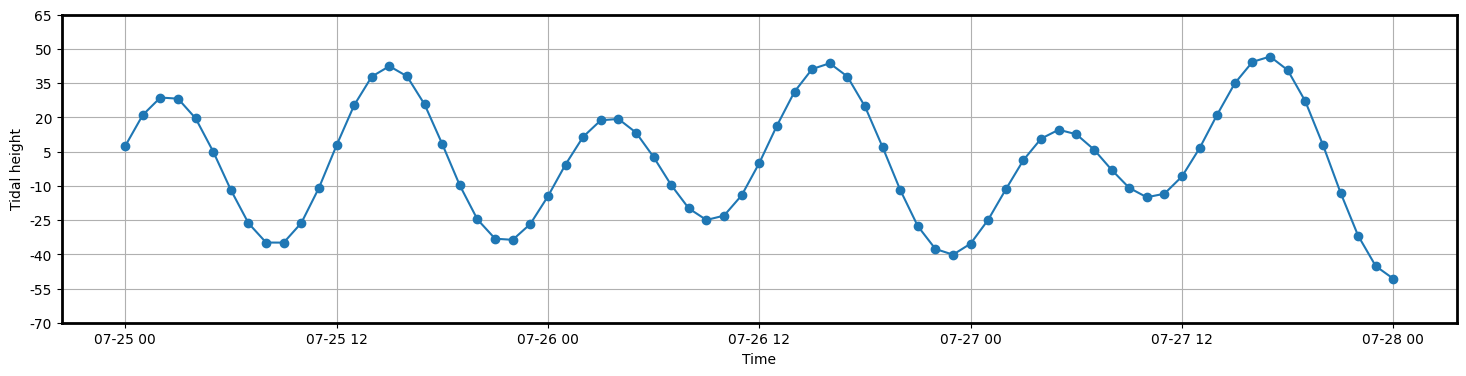

In [12]:
tide = get_tide(amp, ph, constituents, tide_time)
plot_tide(tide, dtime)

In [13]:
# available model list for current
model_list = sorted(model.global_current() + model.antarctic_current())
print(model_list)

['CATS0201', 'CATS2008', 'CATS2008-v2023', 'FES2014', 'HAMTIDE11', 'TPXO7.2', 'TPXO8-atlas', 'TPXO9-atlas', 'TPXO9-atlas-v2', 'TPXO9-atlas-v3', 'TPXO9-atlas-v4', 'TPXO9-atlas-v5', 'TPXO9.1']


In [10]:
#Try TPXO9_atlas_v5
#lon = 122.26672
#lat = 23.76175
lon = 335
lat = 30

# Model parameters
tpxo_model_directory = '/home/bioer/python/tide/data_src'
tpxo_model_format = 'netcdf'
tpxo_compressed = False
tpxo_model_name = 'TPXO9-atlas-v5'
tpxo9_atlas_v5 = get_tide_model(tpxo_model_name, tpxo_model_directory, tpxo_model_format, tpxo_compressed)

In [13]:
# Just test what D is...
#test_constituents = ATLAS.read_constants(tpxo9_atlas_v5.grid_file, tpxo9_atlas_v5.model_file, type=tpxo9_atlas_v5.type, compressed=tpxo9_atlas_v5.compressed)
#test_amp, test_ph, test_D = ATLAS.interpolate_constants(
#                    np.atleast_1d(lon), np.atleast_1d(lat),
#                    test_constituents, type=tpxo9_atlas_v5.type, scale=tpxo9_atlas_v5.scale,
#                    method='spline', extrapolate=True)
#print(test_D)                    

[2991.8019920574575]


In [15]:
tpxo_constituents, tpxo_amp, tpxo_ph = get_tide_constants(lon, lat, tpxo9_atlas_v5, tpxo_model_name)
print(tpxo_amp)
print(tpxo_ph)
print(len(tpxo_constituents))
print(tpxo_amp.shape)
print(tpxo_ph.shape)

[[0.01029563045501709 0.03046309280395508 0.012041594505310059
  0.04177319717407227 0.0822800064086914 0.3977248229980469
  0.0031622776985168457 0.16570153808593752 0.04742364501953125
  0.0022360680103302 0.0014142135381698608 0.0 0.008246211051940918 0.006
  0.0022360680103302]]
[[240.94540412485225 293.19859157749755 41.63354102921778
  47.91083663120176 20.63754635078776 31.532012265659915
  341.5650513452107 51.12418450359888 47.56374007796005 26.56505088990245
  135.00000034162267 -0.0 345.9637563499487 -0.0 333.43494911009753]]
15
(1, 15)
(1, 15)


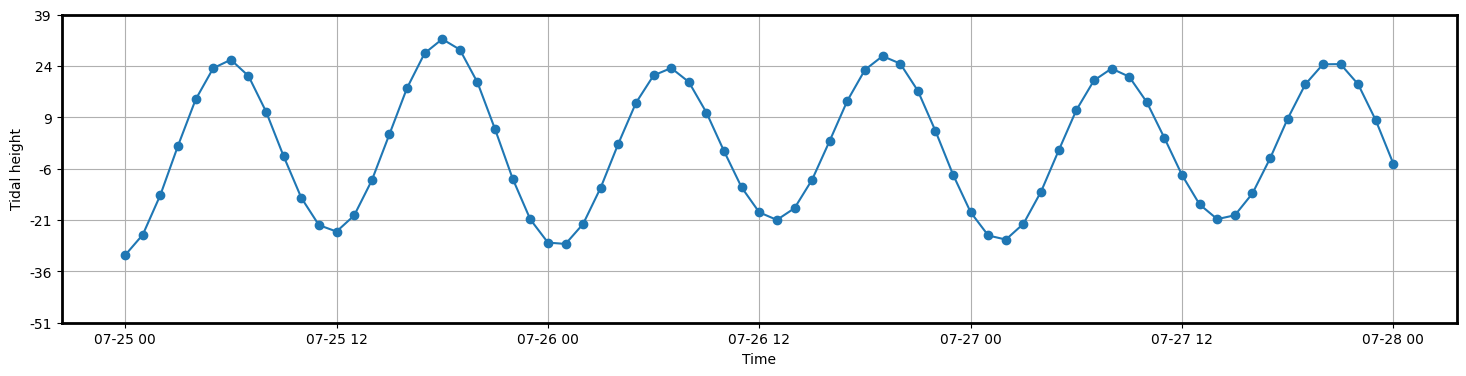

In [16]:
tpxo_tide = get_tide(tpxo_amp, tpxo_ph, tpxo_constituents, tide_time)
plot_tide(tpxo_tide, dtime)

In [11]:
import numpy as np

def bbox2grid(x0, y0, x1, y1, gridx=0.25, gridy=0.25, biasx=0.25/2, biasy=0.25/2):
    # Check if x0=x1, or x1 is absent
    if x0 == x1 or x1 is None:
        gx = np.array([x0])
    else:
        gx = np.arange(x0 + biasx, x1 - biasx + gridx, gridx)
    
    # Check if y0=y1, or y1 is absent
    if y0 == y1 or y1 is None:
        gy = np.array([y0])
    else:
        gy = np.arange(y0 + biasy, y1 - biasy + gridy, gridy)

    glon, glat = np.meshgrid(gx, gy, indexing='xy')
    return glon, glat

# Test the function
x0, y0, x1, y1 = -180, -90, 180, 90
grid = 0.25
glon, glat = bbox2grid(x0, y0, x1, y1, grid, grid)

print(glon.shape)  # (721, 1441) - for grid=0.25
print(glat.shape)  # (721, 1441) - for grid=0.25
print(glon)
print(glat)


(720, 1440)
(720, 1440)
[[-179.875 -179.625 -179.375 ...  179.375  179.625  179.875]
 [-179.875 -179.625 -179.375 ...  179.375  179.625  179.875]
 [-179.875 -179.625 -179.375 ...  179.375  179.625  179.875]
 ...
 [-179.875 -179.625 -179.375 ...  179.375  179.625  179.875]
 [-179.875 -179.625 -179.375 ...  179.375  179.625  179.875]
 [-179.875 -179.625 -179.375 ...  179.375  179.625  179.875]]
[[-89.875 -89.875 -89.875 ... -89.875 -89.875 -89.875]
 [-89.625 -89.625 -89.625 ... -89.625 -89.625 -89.625]
 [-89.375 -89.375 -89.375 ... -89.375 -89.375 -89.375]
 ...
 [ 89.375  89.375  89.375 ...  89.375  89.375  89.375]
 [ 89.625  89.625  89.625 ...  89.625  89.625  89.625]
 [ 89.875  89.875  89.875 ...  89.875  89.875  89.875]]


In [12]:
# Test the function
x0, y0, x1, y1 = 118.0, 20.0, 129.75, 31.25  #-130, 30, -110, 45
#x0, y0, x1, y1 = -30.0, 15, 0, 35
#x0, y0, x1, y1 = 118.0, 20.0, 129.75, 31.25 
#x0, y0, x1, y1 = 122.26672, 23.76175, 129.75, 31.25
grid = 0.25
bias = 0.25/2
glon, glat = bbox2grid(x0, y0, x1, y1, grid, grid, bias, bias)

print(glon.shape) 
print(glat.shape) 
print(glon)
print(glat)
print(glon.ravel())
print(glat.ravel())
print(len(glon.ravel()))
print(isinstance(glon, np.ndarray))
print(glon.ndim)
print(glon.ravel().ndim)

(45, 47)
(45, 47)
[[118.125 118.375 118.625 ... 129.125 129.375 129.625]
 [118.125 118.375 118.625 ... 129.125 129.375 129.625]
 [118.125 118.375 118.625 ... 129.125 129.375 129.625]
 ...
 [118.125 118.375 118.625 ... 129.125 129.375 129.625]
 [118.125 118.375 118.625 ... 129.125 129.375 129.625]
 [118.125 118.375 118.625 ... 129.125 129.375 129.625]]
[[20.125 20.125 20.125 ... 20.125 20.125 20.125]
 [20.375 20.375 20.375 ... 20.375 20.375 20.375]
 [20.625 20.625 20.625 ... 20.625 20.625 20.625]
 ...
 [30.625 30.625 30.625 ... 30.625 30.625 30.625]
 [30.875 30.875 30.875 ... 30.875 30.875 30.875]
 [31.125 31.125 31.125 ... 31.125 31.125 31.125]]
[118.125 118.375 118.625 ... 129.125 129.375 129.625]
[20.125 20.125 20.125 ... 31.125 31.125 31.125]
2115
True
2
1


In [13]:
# Create current model object
def get_current_model(model_name, model_directory, model_format, compressed=False):
    return model(model_directory, format=model_format, compressed=compressed).current(model_name)

tpxo_curr_model = get_current_model(tpxo_model_name, tpxo_model_directory, tpxo_model_format, tpxo_compressed)

In [20]:
print(tpxo_curr_model.model_file)

{'u': [PosixPath('/home/bioer/python/tide/data_src/TPXO9_atlas_v5/u_q1_tpxo9_atlas_30_v5.nc'), PosixPath('/home/bioer/python/tide/data_src/TPXO9_atlas_v5/u_o1_tpxo9_atlas_30_v5.nc'), PosixPath('/home/bioer/python/tide/data_src/TPXO9_atlas_v5/u_p1_tpxo9_atlas_30_v5.nc'), PosixPath('/home/bioer/python/tide/data_src/TPXO9_atlas_v5/u_k1_tpxo9_atlas_30_v5.nc'), PosixPath('/home/bioer/python/tide/data_src/TPXO9_atlas_v5/u_n2_tpxo9_atlas_30_v5.nc'), PosixPath('/home/bioer/python/tide/data_src/TPXO9_atlas_v5/u_m2_tpxo9_atlas_30_v5.nc'), PosixPath('/home/bioer/python/tide/data_src/TPXO9_atlas_v5/u_s1_tpxo9_atlas_30_v5.nc'), PosixPath('/home/bioer/python/tide/data_src/TPXO9_atlas_v5/u_s2_tpxo9_atlas_30_v5.nc'), PosixPath('/home/bioer/python/tide/data_src/TPXO9_atlas_v5/u_k2_tpxo9_atlas_30_v5.nc'), PosixPath('/home/bioer/python/tide/data_src/TPXO9_atlas_v5/u_m4_tpxo9_atlas_30_v5.nc'), PosixPath('/home/bioer/python/tide/data_src/TPXO9_atlas_v5/u_ms4_tpxo9_atlas_30_v5.nc'), PosixPath('/home/bioer/p

In [18]:
print(lon, lat)
print(np.atleast_1d(lon), np.atleast_1d(lat))

122.26672 23.76175
[122.26672] [23.76175]


In [14]:
# Load and interpolate tidal current constants
def get_current_constants(lon, lat, current_model, model_name, TYPE):
    if 'atlas' in model_name:
        amp,ph,D,c = ATLAS.extract_constants(
            np.atleast_1d(lon), np.atleast_1d(lat),
            current_model.grid_file,
            current_model.model_file[TYPE], type=TYPE, method='spline',
            scale=current_model.scale, compressed=current_model.compressed)
                
    return amp, ph, D, c

In [22]:
tpxo_u_amp, tpxo_u_ph, tpxo_u_D, tpxo_u_c = get_current_constants(lon, lat, tpxo_curr_model, tpxo_model_name, "u")


In [23]:
print(tpxo_u_amp)
print(tpxo_u_ph)
print(tpxo_u_amp.shape)
print(tpxo_u_ph.shape)
print(tpxo_u_D)
print(tpxo_u_c)

[[2.2784695233689582 8.451599391925534 4.157581417823648
  12.854680940795562 39.792728931644945 186.4348831009315
  0.9916708157860064 62.90198487778385 17.866184408932668
  1.618426764938067 0.5114858369052488 0.6486163890052282
  4.882326870489642 0.7463545473960711 1.3231312495809266]]
[[224.48746226305957 287.83582756952705 10.234251291962263
  19.438431509911148 340.74628583354996 357.32041092067186
  303.40586874488014 23.56349693838367 20.85372183801866
  62.83233085429466 145.88800489754 20.763293548502276 315.28286420204785
  202.79439896850556 208.67303350410882]]
(1, 15)
(1, 15)
[5412.285489265064]
['q1', 'o1', 'p1', 'k1', 'n2', 'm2', 's1', 's2', 'k2', 'm4', 'ms4', 'mn4', '2n2', 'mf', 'mm']


In [15]:
tmp_u_amp, tmp_u_ph, tmp_u_D, tmp_u_c = get_current_constants(glon.ravel(), glat.ravel(), tpxo_curr_model, tpxo_model_name, "u")
print(tmp_u_amp)
print(tmp_u_ph)
print('----check D----')
print(tmp_u_D)
print(tmp_u_amp.shape)
print(tmp_u_ph.shape)

/home/bioer/.pyenv/versions/3.11.3/envs/py311/lib/python3.11/site-packages/pyTMD/io/ATLAS.py:333: RuntimeWarning: divide by zero encountered in divide
  ampl.data[:,i] = np.abs(hci.data)/unit_conv


[[36.65776759358324 194.4340371981095 79.78498748959527 ...
  7.863314442229785 2.781591390939905 1.4648123892607803]
 [36.322798731273764 192.1945413548701 80.20405550063519 ...
  8.342322457118565 2.838468779782644 1.1384524509351384]
 [36.12975080284833 192.47182624347775 81.0502005074216 ...
  8.479172060307357 2.5121299220920696 0.8719857957710444]
 ...
 [10.161059924855735 67.85021439697634 23.504181661020343 ...
  8.977390851010606 0.07465803593797757 0.09379296750845216]
 [18.644877614206244 106.15707993588322 37.057882767253695 ...
  14.233867132391989 0.15382281198259465 0.08720321646102074]
 [35.96354348159821 203.05434645228559 69.97538880890191 ...
  25.4476817279524 0.26466805201672716 0.06979299155064793]]
[[250.67187354070637 263.1323652284791 303.9850756166864 ...
  142.92162642024678 144.39446109211164 121.37542585322637]
 [245.7552779798886 260.3006849118077 302.0112499842957 ...
  142.9911577459975 133.13281786783793 117.73276302545351]
 [242.84035814780225 258.0112

In [16]:
def get_current(ilon, ilat, tide_time, current_model, model_name):
    DELTAT = np.zeros_like(tide_time)
    timelen = len(tide_time)
    lon = ilon.ravel()
    lat = ilat.ravel()
    nx = ilon.shape[1]
    ny = ilon.shape[0] #shape of ilon, ilat should be the same!
    tide = {}

    for TYPE in ['u', 'v']:
        amp, ph, D, c = get_current_constants(lon, lat, current_model, model_name, TYPE)
        # calculate complex phase in radians for Euler's
        cph = -1j * ph * np.pi / 180.0
        # calculate constituent oscillation
        hc = amp * np.exp(cph)
        tide[TYPE] = np.ma.zeros((ny, nx, timelen))

        for hour in range(timelen):
            # predict tidal elevations at time and infer minor corrections
            TIDE = map(tide_time[hour], hc, c, deltat=DELTAT[hour], corrections=current_model.format)
            MINOR = infer_minor(tide_time[hour], hc, c, deltat=DELTAT[hour], corrections=current_model.format)
            # add major and minor components and reform grid
            # Reshape TIDE and MINOR to have the shape (ny, nx)
            tide[TYPE][:,:,hour] = np.reshape((TIDE+MINOR),(ny,nx))
               
    return tide

In [17]:
gtide = get_current(glon, glat, tide_time[0:1], tpxo_curr_model, tpxo_model_name)

In [21]:
print(gtide)

{'u': masked_array(
  data=[[[21.612923339739645],
         [35.098279364804796],
         [49.036287600284695],
         ...,
         [-38.26422305825506],
         [-39.83860132320653],
         [-40.122640735085675]],

        [[-7.242555387382032],
         [27.13543582304424],
         [45.91606471007905],
         ...,
         [-38.27033518498202],
         [-39.55416677550975],
         [-39.65699648652823]],

        [[-28.837956154631836],
         [32.77351052839707],
         [49.65410798681331],
         ...,
         [-38.21435500259366],
         [-39.43725262107686],
         [-39.870130272408744]],

        ...,

        [[--],
         [--],
         [--],
         ...,
         [-220.01729573120872],
         [-244.36930498117323],
         [-312.32620657683907]],

        [[--],
         [--],
         [--],
         ...,
         [-147.27621060831788],
         [-229.75161398173782],
         [-224.2347248264429]],

        [[--],
         [--],
         [--],
   

In [22]:
# Set the time index (0 to 23)
t = 0
nx = glon.shape[1]
ny = glon.shape[0] #shape of glon, glat should be the same!

# Reshape u and v to 2D
u0 = gtide['u'][:,:,t]*0.01 #.reshape(ny, nx)
v0 = gtide['v'][:,:,t]*0.01 #.reshape(ny, nx)

# Create a grid of indices for subsetting
# ny, nx = np.shape(lon)
X, Y = np.meshgrid(np.arange(nx), np.arange(ny))

# Calculate magnitude of the current
magnitude = np.sqrt(u0**2 + v0**2)

# Normalize the arrows to create a uniform arrow size across the plot
u = u0/magnitude
v = v0/magnitude

print(magnitude)
print(u)
print(v)

n = 1
mask = (X % n == 0) & (Y % n == 0)

x = glon[mask]
y = glat[mask]
u = u[mask]
v = v[mask]
mag = magnitude[mask]

[[0.23744600106193467 0.35971594418249664 0.49311781514268455 ...
  0.3920782573869716 0.40404827353391015 0.40403581646851733]
 [0.07276140147674208 0.28791266050793296 0.4826722638001326 ...
  0.3934036150095625 0.402233363492081 0.4003747798881701]
 [0.35675634190082794 0.42705268805372243 0.6000628921450428 ...
  0.39408120288938164 0.4020164516490916 0.40345289937262757]
 ...
 [-- -- -- ... 2.515044959090618 2.8459186697411454 3.6870251700396386]
 [-- -- -- ... 2.0309650567790034 2.6628707892323082 2.8973441815671204]
 [-- -- -- ... 1.498673808838641 2.5648915775484764 3.6049207644905183]]
[[0.9102247771316307 0.9757220921794392 0.994413223259759 ...
  -0.9759333076327468 -0.9859861787000815 -0.9930466334835949]
 [-0.9953842614888455 0.9424884537960972 0.9512886518188708 ...
  -0.9728008011327445 -0.9833636482093678 -0.9904968664011491]
 [-0.8083375897673121 0.7674348258469275 0.8274817296119568 ...
  -0.9697076318892686 -0.9809860382405564 -0.9882226731895374]
 ...
 [-- -- -- ...

In [25]:
print(np.max(magnitude))
print(np.min(magnitude))
print(np.max(u0))
print(np.min(u0))
print(np.max(v0))
print(np.min(v0))
upercentiles = [1, 10, 20, 30, 40, 50, 75, 90, 99]
u0x = u0.data
u0x[u0.mask] = np.nan
u0x = np.absolute(u0x)
u0x[np.isinf(u0x)] = np.nan
print(u0x)
uvalues = np.nanpercentile(u0x, upercentiles)
print(uvalues)

# Print the results
for p, q in zip(upercentiles, uvalues):
    print(f"{p}th percentile: {q}")

149.32354799342875
0.028550562104523444
134.67032999567732
-25.31487987371166
24.736545055140443
-222.27526011988033
[[0.21612923 0.35098279 0.49036288 ... 0.38264223 0.39838601 0.40122641]
 [0.07242555 0.27135436 0.45916065 ... 0.38270335 0.39554167 0.39656996]
 [0.28837956 0.32773511 0.49654108 ... 0.38214355 0.39437253 0.3987013 ]
 ...
 [       nan        nan        nan ... 2.20017296 2.44369305 3.12326207]
 [       nan        nan        nan ... 1.47276211 2.29751614 2.24234725]
 [       nan        nan        nan ... 0.84414644 2.02635492 3.50477221]]
[1.72720323e-02 1.84377383e-01 3.44019042e-01 4.58457292e-01
 6.92395922e-01 1.34768762e+00 6.53243922e+00 1.54457178e+01
 5.27768021e+01]
1th percentile: 0.017272032321159907
10th percentile: 0.18437738282431732
20th percentile: 0.34401904194651634
30th percentile: 0.4584572918642652
40th percentile: 0.6923959218248352
50th percentile: 1.3476876183254747
75th percentile: 6.532439217723644
90th percentile: 15.445717793110333
99th perce

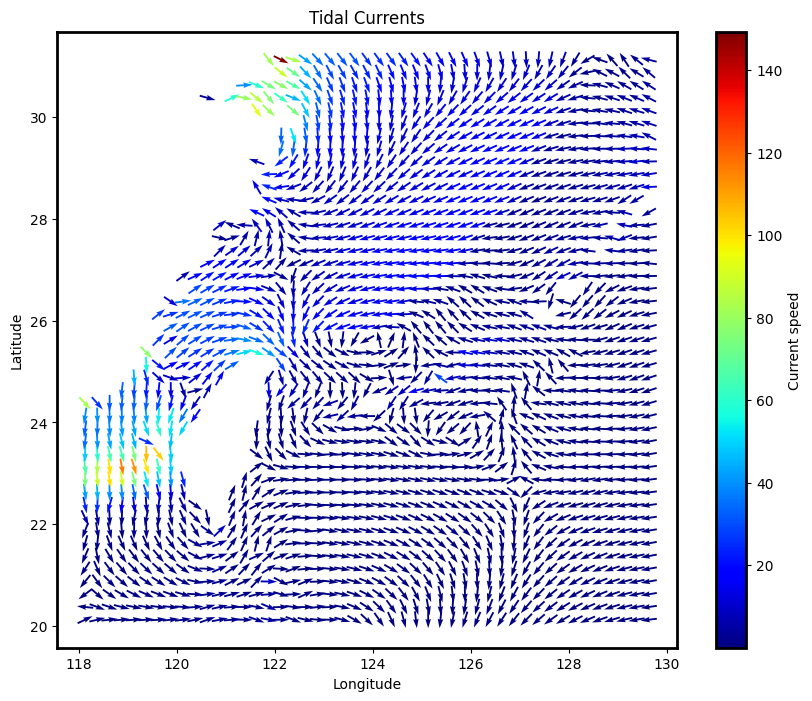

In [24]:
# Calculate magnitude of the current
# Create a figure and plot
fig, ax = plt.subplots(figsize=(10, 8))

# Plotting, note the "angles" and "scale" parameters
plt.colorbar(ax.quiver(x, y, u, v, mag, 
                       angles='xy', scale_units='xy', 
                       scale=3, pivot='middle', width=0.003, cmap='jet'), 
             ax=ax, label='Current speed')

ax.set_title('Tidal Currents')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')


plt.show()